# Variational Continual Learning with Non-Gaussian Variational Distributions

Implementation by Candidate 1079399

## Experiment Setup

In [1]:
# @title Imports

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# @title Utilities (KL-divs, cuda, etc.)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def kl_div_norm(g, h):
    #########################################################
    ###### from eq (5) of doi:10.1348/000711010x522227 ######
    #########################################################
    m, v, m0, v0 = g["mu"], g["sigma"], h["mu"], h["sigma"]
    phi = (v / v0) ** 2
    log_std = torch.log(1 / phi)
    mu_diff = phi + ((m-m0) / v0) ** 2
    return 0.5 * (log_std + mu_diff - 1)
    #########################################################
    #### VCL authors code used this (worse performance?) ####
    #########################################################
    # log_std = torch.log(v0) - v
    # mu_diff = torch.exp(v) + (m-m0)**2 / v0
    # return 0.5 * (log_std + mu_diff - 1)

def kl_div_lapl(g, h):
    m, v, m0, v0 = g["mu"], g["sigma"], h["mu"], h["sigma"]
    psi = torch.abs(m - m0)
    log_std = torch.log(v0 / v)
    mu_diff = (psi + v * torch.exp(-psi/v)) / v0
    return log_std + mu_diff - 1

def calc_acc(outputs, targets):
    return np.mean(outputs.argmax(dim=-1).cpu().numpy() == targets.cpu().numpy())

In [3]:
# @title VCL Layer Construction

class VCL_Layer(nn.Module):
    def __init__(self, in_features, out_features, dist="norm", init_priors=None):
        super().__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.W_size = (out_features, in_features)
        self.b_size = (out_features,)
        self.dist = dist

        if not init_priors:
            init_priors = {
                "mu": 0,
                "sigma": 0.01,
            }

        # "mu" is location parameter of desired distribution
        # "sigma" is scale parameter of desired distribution
        # "rho" is pseudo-scale, use log1p trick to get "sigma" that doesn't cause KL to blow up

        # Initialize weights and biases
        self.W, self.b = nn.ParameterDict(), nn.ParameterDict()
        for k in ["mu", "rho"]:
            self.W[k] = nn.Parameter(torch.Tensor(*self.W_size))
            self.b[k] = nn.Parameter(torch.Tensor(*self.b_size))

        # Initialize prior weights and biases
        self.W_prior, self.b_prior = {}, {}
        for k in ["mu", "sigma"]:
            self.W_prior[k] = torch.tensor(init_priors[k])
            self.b_prior[k] = torch.tensor(init_priors[k])

        self.reset_parameters()

    def reset_parameters(self):
        # Sample "mu" params from desired distribution
        init_loc, init_scale = 0, 0.1
        match self.dist:
            case "lapl":
                lapl_dist = torch.distributions.laplace.Laplace(init_loc, init_scale)
                self.W["mu"].data = lapl_dist.sample(self.W_size)
                self.b["mu"].data = lapl_dist.sample(self.b_size)
            case "genn":
                pass    # not implemented due to inefficiency with our resources
            case _:
                self.W["mu"].data.normal_(init_loc, init_scale)
                self.b["mu"].data.normal_(init_loc, init_scale)

        # Set "rho" params to match VCL authors' code
        self.W["rho"].data.fill_(-3)
        self.b["rho"].data.fill_(-3)

    def forward(self, x, sample=True):
        # local reparametrization trick
        self.W["sigma"] = torch.log1p(torch.exp(self.W["rho"]))
        self.b["sigma"] = torch.log1p(torch.exp(self.b["rho"]))

        act_mu = F.linear(x, self.W["mu"], self.b["mu"])
        act_var = F.linear(x ** 2, self.W["sigma"] ** 2, self.b["sigma"] ** 2)
        act_std = torch.sqrt(act_var + 1e-16)   # offset to ensure nonzero
        if self.training or sample:
            eps = torch.empty_like(act_mu).normal_(0, 1).to(act_mu.device)
            act_mu += act_std * eps
        return act_mu

    def kl_loss(self):
        # determine which KL divergence to use..
        match self.dist:
            case "lapl":
                kl_div_func = kl_div_lapl
            case "genn":
                pass
            case _:
                kl_div_func = kl_div_norm
        # ..and sum it elementwise on all parameters
        return torch.sum(kl_div_func(self.W, self.W_prior)) \
             + torch.sum(kl_div_func(self.b, self.b_prior))

In [4]:
# @title Vanilla + VCL Model Definitions

class Vanilla_Model(nn.Module):
    def __init__(self, tasks):
        super().__init__()
        # all images in SplitMNIST are 28x28 = 784
        # layers: 784 |-> 256 |-> 256 |-> len(t_0) (task 0)
        #                             |-> len(t_1) (task 1)
        #                             |-> len(t_2) (task 2)
        #                             |-> ...

        self.tasks = tasks
        self.hid_layers = nn.ModuleList([
            nn.Linear(784, 256),
            nn.Linear(256, 256),
        ])
        self.heads = nn.ModuleList([nn.Linear(256, len(t)) for t in tasks])

    def forward(self, x, task_id):
        assert task_id in range(len(self.tasks))
        x = x.view(-1, 784)
        for l in self.hid_layers:
            x = F.relu(l(x))
        return self.heads[task_id](x)

class VCL_Model(Vanilla_Model):
    def __init__(self, tasks, dist="norm", init_priors=None):
        super().__init__(tasks)

        self.dist = dist
        self.hid_layers = nn.ModuleList([
            VCL_Layer(784, 256, dist, init_priors),
            VCL_Layer(256, 256, dist, init_priors),
        ])
        self.heads = nn.ModuleList([VCL_Layer(256, len(t), init_priors) for t in tasks])

    # Same `forward` function as `Vanilla_Model`

    def get_kl(self, task_id):
        assert task_id in range(len(self.tasks))
        kl = 0.0
        for l in self.hid_layers:
            kl += l.kl_loss()
        kl += self.heads[task_id].kl_loss()
        return kl

    def update_prior(self):
        for l in self.hid_layers:
            for k in ["mu", "sigma"]:
                l.W_prior[k] = l.W[k]
                l.b_prior[k] = l.b[k]

In [5]:
# @title Train and Test Methods

# Trains Vanilla/VCL model for specific task
def train(model, num_epochs, dataloader, task_id, tot_targets=10, show_progress=True):
    assert task_id in range(len(model.tasks))
    is_vcl = model.__class__ is VCL_Model

    task = model.tasks[task_id]
    optimizer = torch.optim.Adam(model.parameters())

    model.train()
    epochs_iter = tqdm(num_epochs) if show_progress else range(num_epochs)
    stop_after = 5
    stop_thresh = 1e-4
    bad_runs = 0
    last_loss = float('inf')

    for epoch in epochs_iter:
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            # assuming task targets are consecutive, reindex to 0, 1...
            targets -= task[0]
            outputs = torch.zeros(inputs.shape[0], len(task), tot_targets, device=device)
            for i in range(tot_targets):
                net_out = model(inputs, task_id)
                outputs[:, :, i] = F.log_softmax(net_out, dim=-1)
            log_output = torch.logsumexp(outputs, dim=-1) - np.log(tot_targets)
            loss = F.nll_loss(log_output, targets)
            # incorporate KL loss if training VCL model
            if is_vcl:
                num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
                kl = model.get_kl(task_id)
                loss += kl / num_params
            loss.backward()
            optimizer.step()

        # Stop early when not progressing
        bad_runs = 0 if last_loss - loss > stop_thresh else bad_runs + 1
        if bad_runs >= stop_after: break
        last_loss = loss

# Tests Vanilla/VCL model for specific task
def test(model, dataloader, task_id, tot_targets=10):
    assert task_id in range(len(model.tasks))
    task = model.tasks[task_id]
    accs = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        # assuming task targets are consecutive, reindex to 0, 1...
        targets -= task[0]
        outputs = torch.zeros(inputs.shape[0], len(task), tot_targets, device=device)

        for i in range(tot_targets):
            with torch.no_grad():
                net_out = model(inputs, task_id)
            outputs[:, :, i] = F.log_softmax(net_out, dim=-1)

        log_output = torch.logsumexp(outputs, dim=-1) - np.log(tot_targets)
        accs.append(calc_acc(log_output, targets))
    return np.mean(accs)

In [6]:
# @title Get SplitMNIST Dataloaders
# from https://github.com/Piyush-555/VCL-in-PyTorch/tree/main

def _extract_class_specific_idx(dataset, target_classes):
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in target_classes:
        idx |= (dataset.targets==target)
    return idx

def get_split_dataloaders(class_distribution, batch_size=256):
    rsz = 28
    transform = transforms.Compose([
        transforms.Resize((rsz, rsz)),
        transforms.ToTensor(),
    ])

    dataset = torchvision.datasets.MNIST
    trainset = dataset(root="./data", train=True, download=True, transform=transform)
    testset = dataset(root="./data", train=False, download=True, transform=transform)

    dataloaders = []

    for classes in class_distribution:
        train_idx = _extract_class_specific_idx(trainset, classes)
        train_idx = torch.where(train_idx)[0]
        sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        sub_train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size, sampler=sub_train_sampler)

        test_idx = _extract_class_specific_idx(testset, classes)
        test_idx = torch.where(test_idx)[0]
        sub_test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
        sub_test_loader = torch.utils.data.DataLoader(
            testset, batch_size=batch_size, sampler=sub_test_sampler)

        dataloaders.append((sub_train_loader, sub_test_loader))

    return dataloaders

tasks = [ [0, 1], [2, 3], [4, 5], [6, 7], [8, 9] ]
dataloaders = get_split_dataloaders(tasks)

100%|██████████| 9912422/9912422 [00:00<00:00, 119119920.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104970271.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29671240.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19948197.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# @title Coreset Handler

def attach_random_coreset(coresets, dataloader, coreset_size):
    # Shuffle indices
    task_inds = dataloader.sampler.indices
    shuf_inds = task_inds[torch.randperm(len(task_inds))]

    # Separate coreset indices from remaining data
    core_inds, dataloader.sampler.indices = \
        shuf_inds[:coreset_size], shuf_inds[coreset_size:]

    # Attach coreset
    coreloader = torch.utils.data.DataLoader(
        dataloader.dataset,
        batch_size = dataloader.batch_size,
        sampler = torch.utils.data.SubsetRandomSampler(core_inds)
    )
    coresets.append(coreloader)

In [8]:
# @title Experiment Workflow

def run_model(num_tasks, num_epochs, dataloaders, model,
            coreset_method=None, coreset_size=0, update_prior=True, show_progress=True):
    vcl = model.__class__ is VCL_Model
    if torch.cuda.is_available(): model.cuda()

    # Initialize coreset
    coreset_list = []
    all_accs = np.empty((num_tasks, num_tasks))
    for task_id in range(num_tasks):
        if show_progress: print(f"Starting Task {task_id+1}")

        # Train on non-coreset data
        trainloader, testloader = dataloaders[task_id]
        train(model, num_epochs, trainloader, task_id, show_progress=show_progress)
        if show_progress: print(f"Done Training Task {task_id+1}")

        # Attach a new coreset + train on it
        if vcl and coreset_method and coreset_size:
            coreset_method(coreset_list, trainloader, coreset_size)
            for task in range(task_id+1):
                if show_progress: print(f"Replaying Task {task+1}")
                train(model, num_epochs, coreset_list[task], task, show_progress=show_progress)
        if show_progress: print()

        # Evaluate on old tasks
        for task in range(task_id+1):
            _, testloader_i = dataloaders[task]
            acc = test(model, testloader_i, task)
            if show_progress: print(f"Task {task+1} Accuracy: {np.round(acc, 4)}")
            all_accs[task_id][task] = acc
        if show_progress: print()

        # Update prior
        if vcl and update_prior:
            model.update_prior()
    print(np.round(all_accs, 4))
    return all_accs

## Experiments

In [9]:
# @title Task Data

# matching original VCL authors
tasks = [ [0, 1], [2, 3], [4, 5], [6, 7], [8, 9] ]    # @param
dataloaders = get_split_dataloaders(tasks)

In [10]:
# @title Hyperparameters

torch_seed          = 0                         #@param {type:"number"}
torch.manual_seed(0)

num_tasks           = len(tasks)
num_epochs          = 100                       #@param {type:"number"}
coreset_method      = attach_random_coreset
coreset_size        = 200                       #@param {type:"number"}
show_progress       = False                     #@param

In [11]:
# @title Vanilla Model (No VCL)

model = Vanilla_Model(tasks)
vani_accs = run_model(num_tasks, num_epochs, dataloaders, model, show_progress=show_progress)

[[0.9996 0.     0.     0.     0.    ]
 [0.9983 0.9956 0.     0.     0.    ]
 [0.7568 0.954  0.998  0.     0.    ]
 [0.6738 0.8795 0.999  0.9995 0.    ]
 [0.8521 0.8922 0.973  0.9816 0.9956]]


In [12]:
# @title Standard VCL (Gaussian Approximation)

model = VCL_Model(tasks)
norm_accs = run_model(num_tasks, num_epochs, dataloaders, model,
            coreset_method, coreset_size, show_progress=show_progress)

[[0.9983 0.     0.     0.     0.    ]
 [0.9991 0.9946 0.     0.     0.    ]
 [0.9978 0.9804 1.     0.     0.    ]
 [0.9996 0.9721 0.9951 0.9995 0.    ]
 [0.9974 0.9447 0.9863 0.9906 0.9904]]


In [13]:
# @title Modified VCL (Laplacian Approximation)

model = VCL_Model(tasks, dist="lapl")
lapl_accs = run_model(num_tasks, num_epochs, dataloaders, model,
            coreset_method, coreset_size, show_progress=show_progress)

[[0.9996 0.     0.     0.     0.    ]
 [0.9948 0.9917 0.     0.     0.    ]
 [0.9987 0.9892 0.998  0.     0.    ]
 [0.9879 0.9687 0.9871 0.9971 0.    ]
 [0.9948 0.9726 0.9912 0.9909 0.9951]]


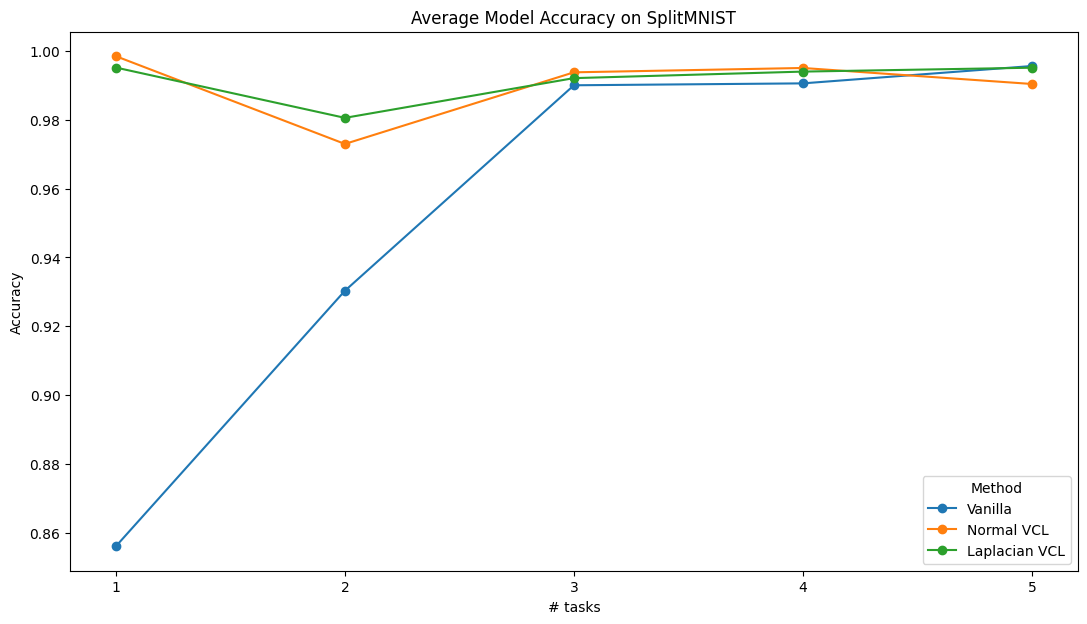

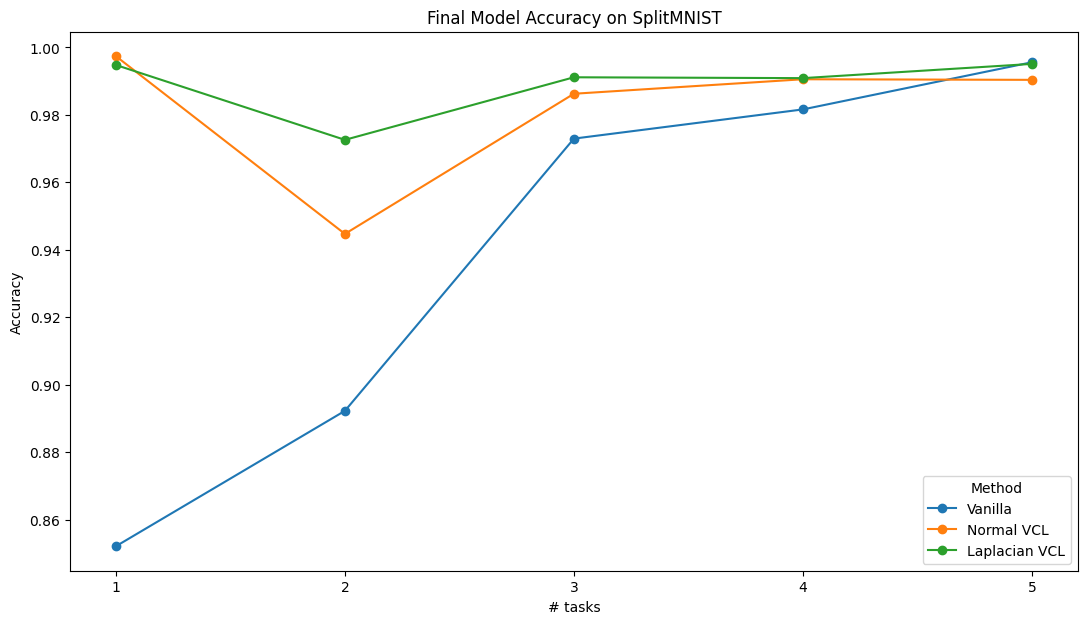

In [14]:
# @title Comparison

data = {
    "Vanilla": vani_accs,
    "Normal VCL": norm_accs,
    "Laplacian VCL": lapl_accs,
}

######## Average Accuracy ########
fig0, ax0 = plt.subplots()
for k in data:
    avg_accs = np.mean(data[k], axis=0, where=(data[k] > 1e-9))
    ax0.plot(np.arange(len(avg_accs))+1, avg_accs, label=k, marker='o')
ax0.set(xticks=list(range(1, len(tasks)+1)),
    xlabel = '# tasks',
    ylabel = 'Accuracy',
    title ='Average Model Accuracy on SplitMNIST'
)
ax0.legend(title='Method')
fig0.set_figwidth(13)
fig0.set_figheight(7)
#--------------------------------#

######### Final Accuracy #########
fig1, ax1 = plt.subplots()
for k in data:
    fin_accs = data[k][-1]
    ax1.plot(np.arange(len(fin_accs))+1, fin_accs, label=k, marker='o')

ax1.set(xticks=list(range(1, len(tasks)+1)),
    xlabel = '# tasks',
    ylabel = 'Accuracy',
    title ='Final Model Accuracy on SplitMNIST'
)
ax1.legend(title='Method')
fig1.set_figwidth(13)
fig1.set_figheight(7)
#--------------------------------#

plt.show()